In [9]:
import os
import pandas as pd

# Đường dẫn thư mục dữ liệu gốc và thư mục lưu kết quả
input_folder = r"data/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc_csv"
output_folder = r"processed_data"

# Tạo thư mục processed_data nếu chưa tồn tại
os.makedirs(output_folder, exist_ok=True)
processed_person_count = 0
# Số lượng người: 01 đến 53
for i in range(1, 54):
    full_processed = True

    # Định dạng số với 2 chữ số
    subj_id = f"{i:02d}"
    # Tạo thư mục con cho mỗi người
    subj_folder = os.path.join(output_folder, f"bidmc_{subj_id}")
    os.makedirs(subj_folder, exist_ok=True)
    
    # Đường dẫn file
    signals_file = os.path.join(input_folder, f"bidmc_{subj_id}_Signals.csv")
    numerics_file = os.path.join(input_folder, f"bidmc_{subj_id}_Numerics.csv")
    breaths_file = os.path.join(input_folder, f"bidmc_{subj_id}_Breaths.csv")
    
    # 1. Đọc và trích xuất từ Signals: chỉ lấy cột "Time [s]" và "PLETH"
    if os.path.exists(signals_file):
        df_signals = pd.read_csv(signals_file)
        df_signals.columns = df_signals.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_signals.columns and 'PLETH' in df_signals.columns:
            df_signals = df_signals[['Time [s]', 'PLETH']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False
        # Lưu file đã xử lý
        df_signals.to_csv(os.path.join(subj_folder, "Signals_processed.csv"), index=False)
    
    # 2. Đọc và trích xuất từ Numerics: lấy cột "Time [s]", "HR" và "RESP"
    if os.path.exists(numerics_file):
        df_numerics = pd.read_csv(numerics_file)
        df_numerics.columns = df_numerics.columns.str.strip()

        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_numerics.columns and 'HR' in df_numerics.columns and 'RESP' in df_numerics.columns:
            df_numerics = df_numerics[['Time [s]', 'HR', 'RESP']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False

        # Lưu file đã xử lý
        df_numerics.to_csv(os.path.join(subj_folder, "Numerics_processed.csv"), index=False)
    
    # 3. Đọc và trích xuất từ Breath: chọn cột annotator (ví dụ: đặt lại tên thành "ann1", "ann2")
    if os.path.exists(breaths_file):
        df_breaths = pd.read_csv(breaths_file)
        df_breaths.columns = df_breaths.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'breaths ann1 [signal sample no]' in df_breaths.columns and 'breaths ann2 [signal sample no]' in df_breaths.columns:
            # Đổi tên cột cho dễ đọc
            rename_dict = {}
            for col in df_breaths.columns:
                if "ann1" in col.lower():
                    rename_dict[col] = "ann1"
                elif "ann2" in col.lower():
                    rename_dict[col] = "ann2"
            if rename_dict:
                df_breaths.rename(columns=rename_dict, inplace=True)

            df_breaths = df_breaths[['ann1', 'ann2']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False
        # Giả sử tên cột ban đầu là "breaths ann1 [signal sample no]" và "breaths ann2 [signal sample no]"
        
        # Lưu file đã xử lý
        df_breaths.to_csv(os.path.join(subj_folder, "Breaths_processed.csv"), index=False)
    if not full_processed:
        print(f"Không đúng tên cột hoặc không đủ dữ liệu dữ liệu cho người {subj_id}. Bỏ qua.")
        continue
    processed_person_count += 1

# Thông báo đã xử lý xong một người
print(f"Đã xử lý dữ liệu cho {processed_person_count} người.")

# Sau khi xử lý xong, ta sẽ làm sạch dữ liệu trong các file đã lưu trong thư mục processed_data
print("Bắt đầu làm sạch dữ liệu...")

# Sau khi lưu dữ liệu, ta load lại dữ liệu từ processed_data để xử lý các giá trị null hoặc không hợp lệ
# Ví dụ: điền giá trị bị thiếu (fillna) với phương pháp forward fill, và sau đó loại bỏ nếu vẫn còn null.
def clean_dataframe(df, method='ffill'):
    # Áp dụng forward fill
    # df_clean = df.fillna(method=method)
    if method == 'ffill':
        df_clean = df.ffill()
    elif method == 'bfill':
        df_clean = df.bfill()
    else:
        raise ValueError("Chỉ hỗ trợ 'ffill' hoặc 'bfill'")
    # Nếu vẫn còn null, loại bỏ các dòng chứa null
    df_clean = df_clean.dropna()
    return df_clean

# Duyệt qua từng thư mục con và làm sạch dữ liệu
for subj in os.listdir(output_folder):
    subj_path = os.path.join(output_folder, subj)
    if os.path.isdir(subj_path):
        # Danh sách file đã xử lý trong thư mục của người đó
        for file_name in os.listdir(subj_path):
            if file_name.endswith("_processed.csv"):
                file_path = os.path.join(subj_path, file_name)
                df = pd.read_csv(file_path)
                df_clean = clean_dataframe(df)
                # Lưu lại file sau khi làm sạch (có thể ghi đè file cũ)
                df_clean.to_csv(file_path, index=False)
                
print("Đã trích xuất và làm sạch dữ liệu vào thư mục 'processed_data'.")


Đã xử lý dữ liệu cho 53 người.
Bắt đầu làm sạch dữ liệu...
Đã trích xuất và làm sạch dữ liệu vào thư mục 'processed_data'.


## Xem dữ liệu

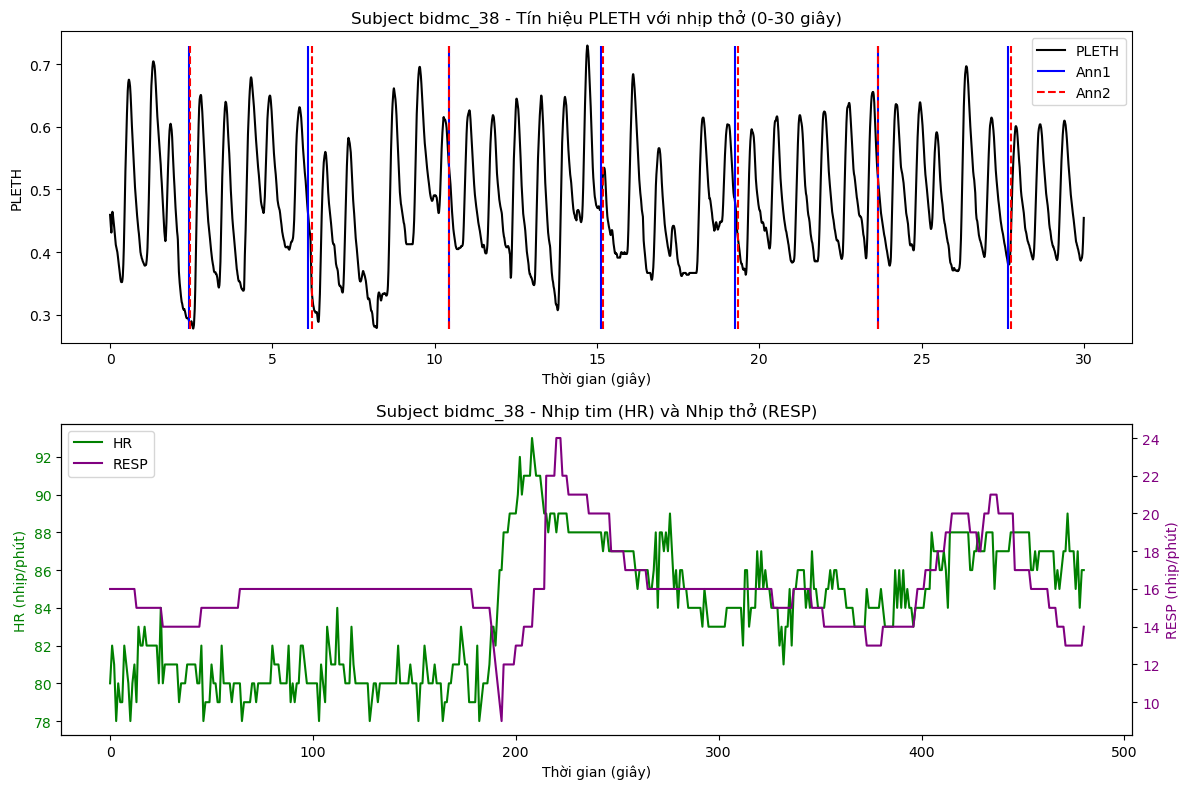

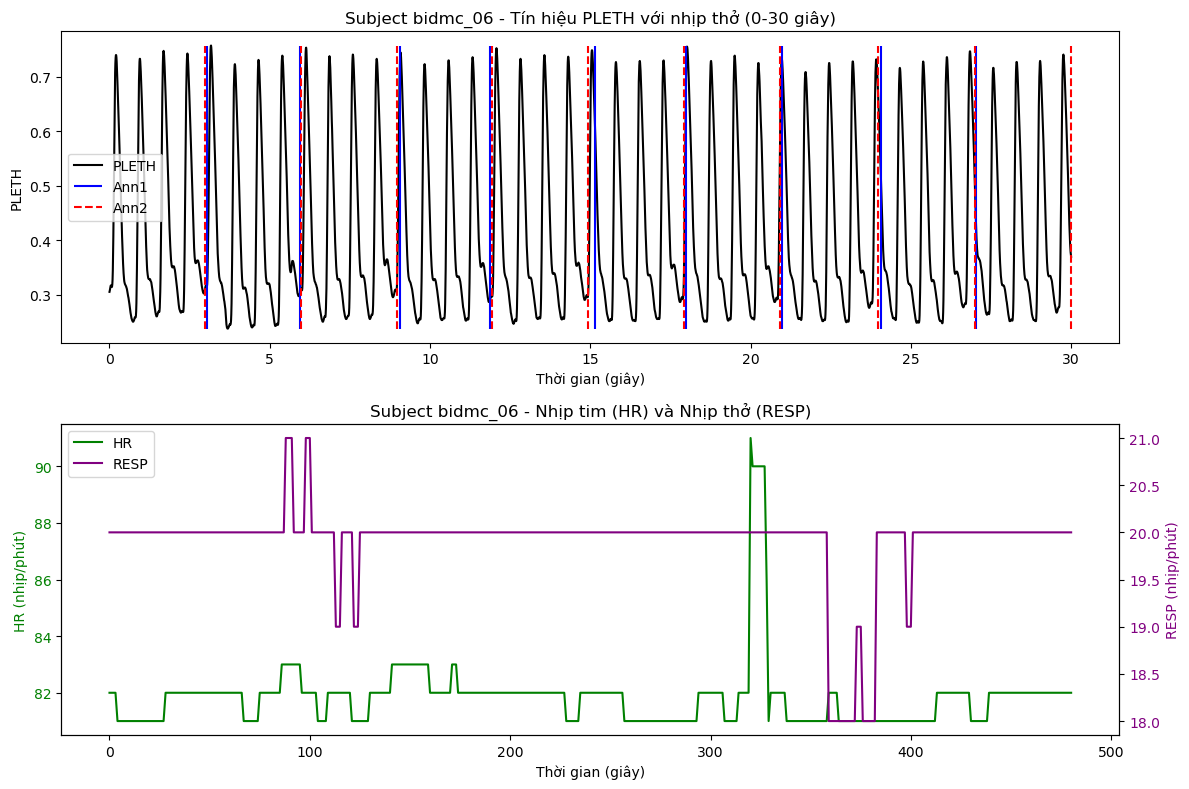

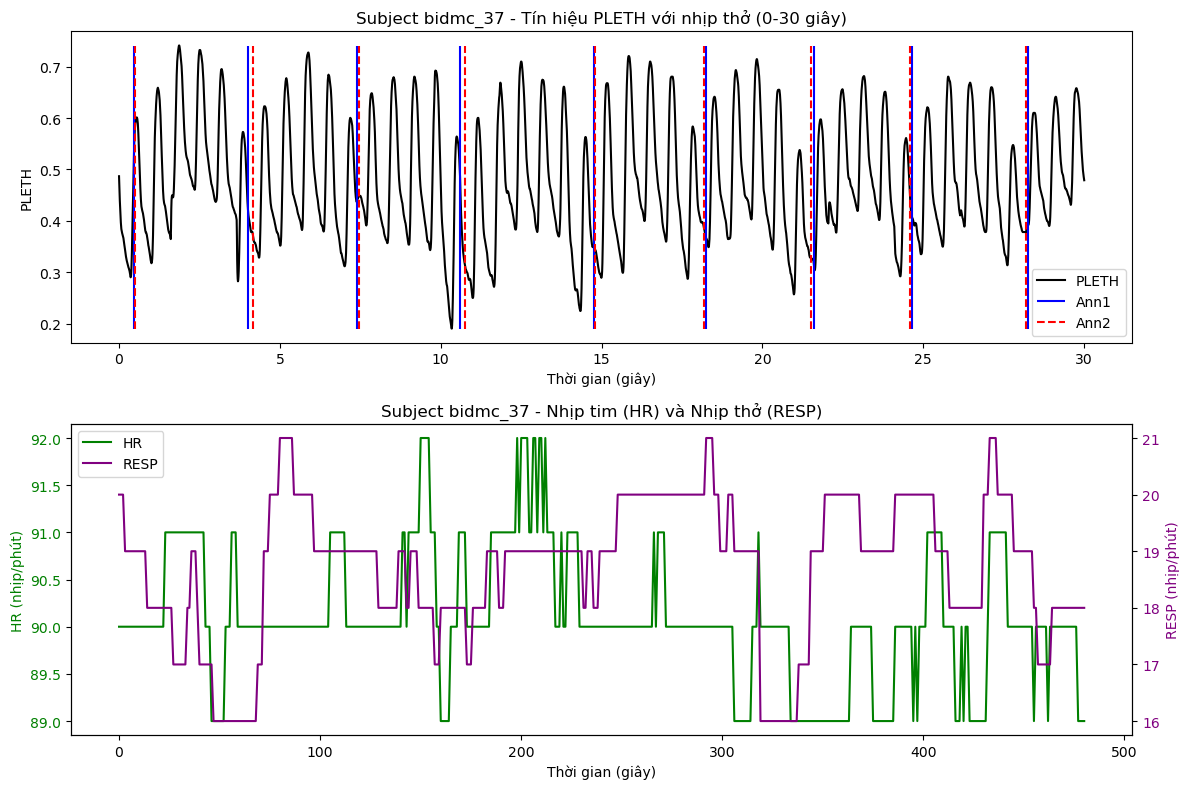

In [ ]:
import matplotlib.pyplot as plt
import random

# Đường dẫn đến dữ liệu đã xử lý
base_dir = "processed_data"

# Tạo danh sách các subject IDs từ 01 đến 53
subject_ids = [f"{i:02d}" for i in range(1, 54)]

# Chọn ngẫu nhiên 3 subject
selected_subjects = random.sample(subject_ids, 3)

# Lặp qua từng subject được chọn
for subject in selected_subjects:
    # Tạo đường dẫn đến thư mục của subject
    subject_dir = os.path.join(base_dir, f"bidmc_{subject}")
    
    # Đọc các file CSV
    df_signals = pd.read_csv(os.path.join(subject_dir, 'Signals_processed.csv'))
    df_breaths = pd.read_csv(os.path.join(subject_dir, 'Breaths_processed.csv'))
    df_numerics = pd.read_csv(os.path.join(subject_dir, 'Numerics_processed.csv'))
    
    # Lấy đoạn tín hiệu PLETH từ 0 đến 30 giây
    pleth_segment = df_signals[df_signals['Time [s]'] <= 30]
    
    # Đảm bảo các sample number của breath annotations nằm trong phạm vi tín hiệu
    max_sample = len(df_signals) - 1
    valid_ann1 = df_breaths['ann1'][df_breaths['ann1'] <= max_sample]
    valid_ann2 = df_breaths['ann2'][df_breaths['ann2'] <= max_sample]
    
    # Chuyển sample number thành thời gian và lọc trong khoảng 0-30 giây
    breath_times_ann1 = df_signals['Time [s]'].iloc[valid_ann1]
    breath_times_ann1_segment = breath_times_ann1[breath_times_ann1 <= 30]
    
    breath_times_ann2 = df_signals['Time [s]'].iloc[valid_ann2]
    breath_times_ann2_segment = breath_times_ann2[breath_times_ann2 <= 30]
    
    # Tạo figure với 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Biểu đồ 1: PLETH signal với breath annotations
    ax1.plot(pleth_segment['Time [s]'], pleth_segment['PLETH'], label='PLETH', color='black')
    ax1.vlines(breath_times_ann1_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='blue', linestyles='solid', label='Ann1')
    ax1.vlines(breath_times_ann2_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='red', linestyles='dashed', label='Ann2')
    ax1.set_xlabel('Thời gian (giây)')
    ax1.set_ylabel('PLETH')
    ax1.legend()
    ax1.set_title(f'Subject bidmc_{subject} - Tín hiệu PLETH với nhịp thở (0-30 giây)')
    
    # Biểu đồ 2: HR và RESP
    ax2.plot(df_numerics['Time [s]'], df_numerics['HR'], color='green', label='HR')
    ax2.set_xlabel('Thời gian (giây)')
    ax2.set_ylabel('HR (nhịp/phút)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Tạo trục y thứ hai cho RESP
    ax2_r = ax2.twinx()
    ax2_r.plot(df_numerics['Time [s]'], df_numerics['RESP'], color='purple', label='RESP')
    ax2_r.set_ylabel('RESP (nhịp/phút)', color='purple')
    ax2_r.tick_params(axis='y', labelcolor='purple')
    
    # Thêm legend cho cả HR và RESP
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_r.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    ax2.set_title(f'Subject bidmc_{subject} - Nhịp tim (HR) và Nhịp thở (RESP)')
    
    # Điều chỉnh layout để tránh overlap
    plt.tight_layout()

# Hiển thị tất cả các biểu đồ
plt.show()

## Bắt đầu lọc nhiễu

In [10]:
import pandas as pd
import numpy as np

# Đọc dữ liệu
ppg_data = pd.read_csv(r'processed_data\bidmc_01\Signals_processed.csv')  # PPG
numeric_data = pd.read_csv(r'processed_data\bidmc_01\Numerics_processed.csv')  # HR, RESP

# Giả sử cột: 'Time [s]', 'PPG', 'HR', 'RESP'
segments = []
conditions = []
segment_length = 125  # 1 giây

for t in range(0, len(ppg_data) // segment_length):
    start_idx = t * segment_length
    end_idx = start_idx + segment_length
    if end_idx <= len(ppg_data):
        ppg_segment = ppg_data['PLETH'].iloc[start_idx:end_idx].values
        hr = numeric_data['HR'].iloc[t]
        resp = numeric_data['RESP'].iloc[t]
        segments.append(ppg_segment)
        conditions.append([hr, resp])

segments = np.array(segments)  # Shape: (num_segments, 125)
conditions = np.array(conditions)  # Shape: (num_segments, 2)

In [11]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa PPG
segments_normalized = []
for seg in segments:
    scaler = StandardScaler()
    seg_normalized = scaler.fit_transform(seg.reshape(-1, 1)).flatten()
    segments_normalized.append(seg_normalized)
segments_normalized = np.array(segments_normalized)

# Chuẩn hóa HR và RESP
scaler_condition = StandardScaler()
conditions_normalized = scaler_condition.fit_transform(conditions)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, C_train, C_test = train_test_split(
    segments_normalized, conditions_normalized, test_size=0.2, random_state=42
)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim=125, condition_dim=2, latent_dim=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + condition_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
    
    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)  # Shape: (batch_size, 125+2)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=10, condition_dim=2, output_dim=125):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_dim)
    
    def forward(self, z, condition):
        z = torch.cat([z, condition], dim=1)  # Shape: (batch_size, 10+2)
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_recon = self.fc3(h)  # Không activation để giữ giá trị thực
        return x_recon

In [15]:
class CVAE(nn.Module):
    def __init__(self, input_dim=125, condition_dim=2, latent_dim=10):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, condition_dim, latent_dim)
        self.decoder = Decoder(latent_dim, condition_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x, condition):
        mean, logvar = self.encoder(x, condition)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decoder(z, condition)
        return x_recon, mean, logvar

In [16]:
def loss_function(x_recon, x, mean, logvar, beta=1.0):
    mse = F.mse_loss(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return mse + beta * kl

In [18]:
from torch.utils.data import DataLoader, TensorDataset

# Chuyển thành tensor
X_train_tensor = torch.FloatTensor(X_train)
C_train_tensor = torch.FloatTensor(C_train)
train_dataset = TensorDataset(X_train_tensor, C_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Khởi tạo mô hình và optimizer
cvae = CVAE()
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# Huấn luyện
num_epochs = 500
for epoch in range(num_epochs):
    cvae.train()
    total_loss = 0
    for x, condition in train_loader:
        x_recon, mean, logvar = cvae(x, condition)
        loss = loss_function(x_recon, x, mean, logvar, beta=0.5)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 3917.8054
Epoch 2, Loss: 2372.4884
Epoch 3, Loss: 1236.0939
Epoch 4, Loss: 923.3151
Epoch 5, Loss: 759.9324
Epoch 6, Loss: 679.4302
Epoch 7, Loss: 635.7961
Epoch 8, Loss: 603.9653
Epoch 9, Loss: 563.1153
Epoch 10, Loss: 546.5607
Epoch 11, Loss: 537.2440
Epoch 12, Loss: 518.5065
Epoch 13, Loss: 501.8573
Epoch 14, Loss: 475.9028
Epoch 15, Loss: 453.3506
Epoch 16, Loss: 421.2516
Epoch 17, Loss: 410.5304
Epoch 18, Loss: 401.1171
Epoch 19, Loss: 401.8355
Epoch 20, Loss: 396.2265
Epoch 21, Loss: 396.0392
Epoch 22, Loss: 377.9766
Epoch 23, Loss: 383.7951
Epoch 24, Loss: 395.1226
Epoch 25, Loss: 378.8344
Epoch 26, Loss: 374.6759
Epoch 27, Loss: 365.1822
Epoch 28, Loss: 360.3996
Epoch 29, Loss: 359.4087
Epoch 30, Loss: 356.5708
Epoch 31, Loss: 349.5587
Epoch 32, Loss: 355.8929
Epoch 33, Loss: 355.6828
Epoch 34, Loss: 344.5291
Epoch 35, Loss: 345.2917
Epoch 36, Loss: 338.6365
Epoch 37, Loss: 331.2041
Epoch 38, Loss: 337.8507
Epoch 39, Loss: 337.4758
Epoch 40, Loss: 331.5022
Epoch 

In [22]:
cvae.eval()
with torch.no_grad():
    # Tạo mẫu ngẫu nhiên từ phân phối chuẩn
    z = torch.randn(10, 10)  # 10 mẫu, latent_dim=10
    # Điều kiện ví dụ
    condition = torch.FloatTensor([[60, 12], 
                                   [80, 15], 
                                   [70, 18], 
                                   [80, 16], 
                                   [85, 17], 
                                   [83, 18],
                                   [85, 19],
                                   [72, 20], 
                                   [67, 21],
                                   [77, 23]])  # HR, RESP
    ppg_generated = cvae.decoder(z, condition)

In [23]:
X_test_tensor = torch.FloatTensor(X_test)
C_test_tensor = torch.FloatTensor(C_test)
cvae.eval()
with torch.no_grad():
    x_recon, _, _ = cvae(X_test_tensor, C_test_tensor)
    mse = F.mse_loss(x_recon, X_test_tensor).item()
    print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0471


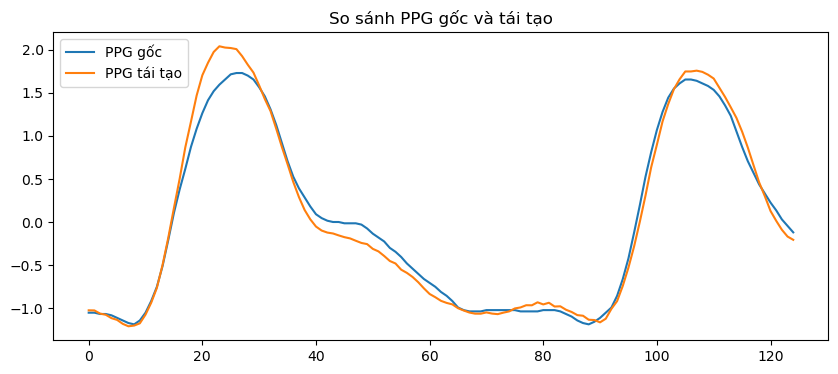

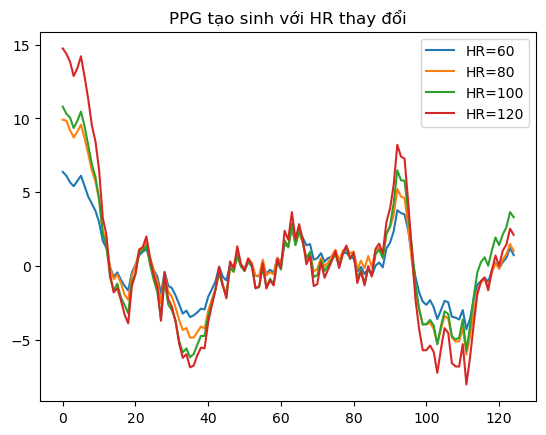

In [25]:
import matplotlib.pyplot as plt

# So sánh PPG gốc và tái tạo
plt.figure(figsize=(10, 4))
plt.plot(X_test[0], label='PPG gốc')
plt.plot(x_recon[0].numpy(), label='PPG tái tạo')
plt.legend()
plt.title("So sánh PPG gốc và tái tạo")
plt.show()

# Tạo PPG với HR tăng dần
hr_values = [60, 80, 100, 120]
for hr in hr_values:
    condition = torch.FloatTensor([[hr, 15]])  # RESP cố định
    ppg_gen = cvae.decoder(torch.randn(1, 10), condition)
    plt.plot(ppg_gen[0].detach().numpy(), label=f'HR={hr}')
plt.legend()
plt.title("PPG tạo sinh với HR thay đổi")
plt.show()